Analysis code for

# Prevalence of delusional themes among patients with psychosis: a systematic review and meta-analysis

Analysis of data from validated, structured assessments only

In [14]:
library(metafor)
library(dplyr)
library(stringr)
library(forester) # from https://github.com/rdboyes/forester
library(dmetar)   # from https://dmetar.protectlab.org/articles/dmetar
library(doParallel)
library(clubSandwich)
library(table1)
library(flextable)
library(tibble)
library(IRdisplay)

In [15]:
# Record start time of entire analysis
overall_start_time <- Sys.time()

In [16]:
# Make sure we're using the metafor harmonic mean of sample sizes back-transformation
transf.ipft.hm <- metafor::transf.ipft.hm

Read in data files

In [17]:
delus_themes_data_raw <- read.csv("/home/main/Dropbox/Studies/EllieDelusionsSysReview/AnalysisCode/target_themes_df_long_24.csv", header = TRUE)
human_friendly_labels <- read.csv("/home/main/Dropbox/Studies/EllieDelusionsSysReview/AnalysisCode/HumanFriendlyLabels.csv", header = TRUE)

Do some tidying up of data

In [18]:
# Correct all theme names by removing "n_" prefix
delus_themes_data_raw <- delus_themes_data_raw %>% 
  mutate(theme = str_replace(theme, "n_",""))

# Add effect size ID (row ID) column for hierarchical clustering
delus_themes_data_raw <- delus_themes_data_raw %>% 
  mutate(es_id = paste0("id_", row_number()))

# Remove 'other' categories
delus_themes_data <- delus_themes_data_raw %>% 
  filter(theme != "other") %>%
  filter(theme != "anydelusion") %>%
  filter(theme != "unspecified")

Function for running meta-analysis

In [19]:
#
# run_meta: Function to run multivariate, multilevel meta-analysis give input data 
#
# Parameters:
#  data_in: dataframe with meta-analysis data
#  sparse_option: switch for sparse option for the rma.mv meta-analysis.
#                 It massively speeds up the calculation but prevents I2 being
#                 calculated because var.comp can't run on sparse matrices. Therefore,
#                 this needs to be switched off for main meta-analysis where I2 is needed
# Returns:
#  dataframe with prevalences and extra information for forest plot
#
# Note <<- assignment in places to key variables are global and accessible outside the function

run_meta <- function(data_in, sparse_option = TRUE, rho_value = 0.5) {

  # Calculate effect sizes and sampling variance for proportion
  # using Freeman-Tukey double arcsine transformed proportion
  ef_calc <<- escalc(xi = cases, ni = psychotic_n, data = data_in, measure = "PFT", add = 0) 

  # Create variance-covariance matrix of dependent effect sizes given that many studies report
  # several prevalences. Assume that the effect sizes within studies are correlated with rho = 0.5 
  V_mat <<- vcalc(vi, cluster = study_sample, obs = es_id, data = ef_calc, rho = rho_value)

  # Multivariate, multilevel meta-analysis moderated by delusion theme
  # to get individual theme estimates
  meta_model <<- rma.mv(yi = yi, V = V_mat,
                        slab = study_sample,
                        random = ~ 1 | study_sample / es_id,
                        mods = ~ theme - 1,
                        method = "REML",
                        level = 95,
                        digits = 3,
                        sparse = sparse_option,
                        data = ef_calc)

  # Get list of themes and number of themes
  themes_list <- names(colMeans(model.matrix(meta_model)))
  theme_count <- length(themes_list)

  # To get the actual prevalence estimates, we need to backtransform from the PFT values
  # used in the meta-analysis. We need to do this by moderator because each moderator is
  # a delusion theme. To do this we need to use predict, we requires a model matrix to identify
  # each moderator. As the theme moderator has theme_count levels (themes), each one is indicated by
  # a vector of theme_count zeroes with a 1 in the position to mark its level.

  # To get backtransformed prevalences for theme_count themes, we need a theme_count x theme_count matrix with each line
  # indicating the next theme. Therefore, the following code creates a n x n matrix of stacked
  # vectors each with the position marked by 1 on each row to identify the level of the moderator

  vec_list <- c()
  for (i in 1:theme_count) {
    my_vector <- rep(0, theme_count)
    my_vector[i] <- 1
    new_vec <- my_vector
    vec_list <- rbind(vec_list, new_vec)
  }

  # Get the backtransformed estimates from the meta-analysis
  estimate_df <- as.data.frame(predict(meta_model, newmods = vec_list, transf = transf.ipft.hm, targs = list(ni = data_in$psychotic_n)))

  # Add in the theme labels
  estimate_df$theme <- themes_list

  # Remove appended 'theme' string from meta-analysis labeling the moderator to make it human friendly
  estimate_df$theme <- gsub("theme", "", estimate_df$theme)

  # Calculate total cases per theme
  cases_per_theme <- data_in %>%
    group_by(theme) %>%
    summarize(Total_cases = sum(cases))

  # Calculate sample N per theme
  N_per_theme <- data_in %>%
    group_by(theme) %>%
    summarize(psychotic_n = sum(psychotic_n))

  # Calculate k cases per theme
  k_per_theme <- data_in %>%
    group_by(theme) %>%
    summarize(k = n())

  # ...and these into the estimate_df dataframe
  estimate_df <- estimate_df %>%
    left_join(cases_per_theme, by = "theme") %>%
    left_join(N_per_theme, by = "theme") %>%
    left_join(k_per_theme, by = "theme")

  #
  # Tidy up dataframe
  #
  
  # Delete these columns
  estimate_df$pi.lb <- NULL
  estimate_df$pi.ub <- NULL

  # Rename pred as prevalence
  estimate_df <- estimate_df %>% 
    rename(prevalence = pred)

  # Put columns in more sensible order
  new_order <- c("theme", "prevalence", "ci.lb", "ci.ub", "Total_cases", "psychotic_n", "k")
  estimate_df <- estimate_df[new_order]

  # Create a human friendly estimate string from the values and put it in est_str
  estimate_df <- estimate_df %>%
    mutate(est_str = sprintf("%.2f%% (%.2f - %.2f)", prevalence * 100, ci.lb * 100, ci.ub * 100))
  
  return(estimate_df)
}


Function for generating a forest plot from the dataframe of theme prevalences outputted by run_meta

In [20]:
#
# forester_plot: Function to generate a forest plot from the dataframe of theme prevalences outputted by run_meta using the forester package
#
# Parameters:
#  results_df: dataframe with themes, prevalences, and confidence intervals from run_meta
#  max_ci_ub: the upper limit of the prevalence scale for the plot
#  file_path: the path to write the PNG file
#  sparse_option: switch for sparse option for the rma.mv meta-analysis.
#                 It massively speeds up the calculation but prevents I2 being
#                 calculated because var.comp can't run on sparse matrices. Therefore,
#                 this needs to be switched off for main meta-analysis where I2 is needed
# Returns:
#  nothing
#
forester_plot <- function(results_df, max_ci_ub, file_path) {
  forest_df <- results_df %>%
    arrange(desc(prevalence))
  
  forest_df <- forest_df %>%
    left_join(human_friendly_labels, by = "theme")
  
  # Extract column for the left side column needed for forester
  forest_df_lsd <- forest_df %>%
    select("Theme of delusion" = label, "Total cases" = Total_cases, "Sample N" = psychotic_n, k)
  
  # Extract columns for the right side column needed for forester (and round Q to 2 decimals places)
  forest_df_rsd <- forest_df %>%
    select("Estimate (95% CI)" = est_str)
  
  # Plot as forest plot
  if (plot == 1) {
    forester(left_side_data = forest_df_lsd,
             right_side_data = forest_df_rsd,
             estimate = forest_df$prevalence,
             ci_low = forest_df$ci.lb,
             ci_high = forest_df$ci.ub,
             stripe_colour = "#ffffff",
             estimate_precision = 2,
             font_family = "sans",
             ggplot_width = 30,
             nudge_x = 1,
             xlim = c(-0.05, max_ci_ub),
             file_path = file_path,
             display = FALSE)
  }
}

### Analyis begins

Include only validated studies and filter out non-independent 'various' categories

In [21]:
# Only keep studies using validated measures
delus_themes_data_val_only <- delus_themes_data %>% 
  filter(validatedmeasure == "Validated")

# Remove 'number of theme' categories
delus_themes_data_val_only <- delus_themes_data_val_only %>% 
  filter(theme != "monothematic") %>%
  filter(theme != "polythematic") %>%
  filter(theme != "systemised") %>%
  filter(theme != "mixed_multiple_various")

Combine very similar categories

In [22]:
# Combine categories
delus_themes_data_recoded <- delus_themes_data_val_only %>%
  mutate(theme = recode(theme, "grandiose_grandioseability_grandeur" = "grandiose")) %>%
  mutate(theme = recode(theme, "identity_grandioseidentity" = "grandiose")) %>%
  mutate(theme = recode(theme, "socialstatus_beingpolitical_royalfamily_king_hero" = "grandiose")) %>%
  mutate(theme = recode(theme, "socialstatus(famous_king_celebrity_sociallydistinguished)" = "grandiose")) %>%
  mutate(theme = recode(theme, "paranoid" = "persecutory_paranoid")) %>%
  mutate(theme = recode(theme, "persecutory" = "persecutory_paranoid")) %>%
  mutate(theme = recode(theme, "god_jesus_prophet_religiousbeingspecialrelationcommunication" = "religious")) %>%
  mutate(theme = recode(theme, "thoughtbroadcasting_spokenaloud_dissemination" = "thought_broadcast")) %>%
  mutate(theme = recode(theme, "thoughtecho_gedankenlautwerden" = "thought_broadcast")) %>%
  mutate(theme = recode(theme, "thoughtecho" = "thought_broadcast"))

Only include themes that have prevalence estimated by at least 10 samples

In [23]:
# Remove themes with less than 10 samples that estimate them
k_per_theme <- delus_themes_data_recoded %>%
  group_by(theme) %>%
  summarize(k = n())

delus_themes_data_recoded_min_k <- delus_themes_data_recoded %>%
  left_join(k_per_theme, by = "theme")

delus_themes_data_recoded_min_k <- delus_themes_data_recoded_min_k %>%
  filter(!(k < 10))


#### Run the main meta-analysis
...without sparse matrix calculation so we can calculate I2 in heterogeneity metrics section

In [24]:
estimate_df <- run_meta(delus_themes_data_recoded_min_k, sparse_option = FALSE)

Generate the forest plot of delusion prevalences by theme

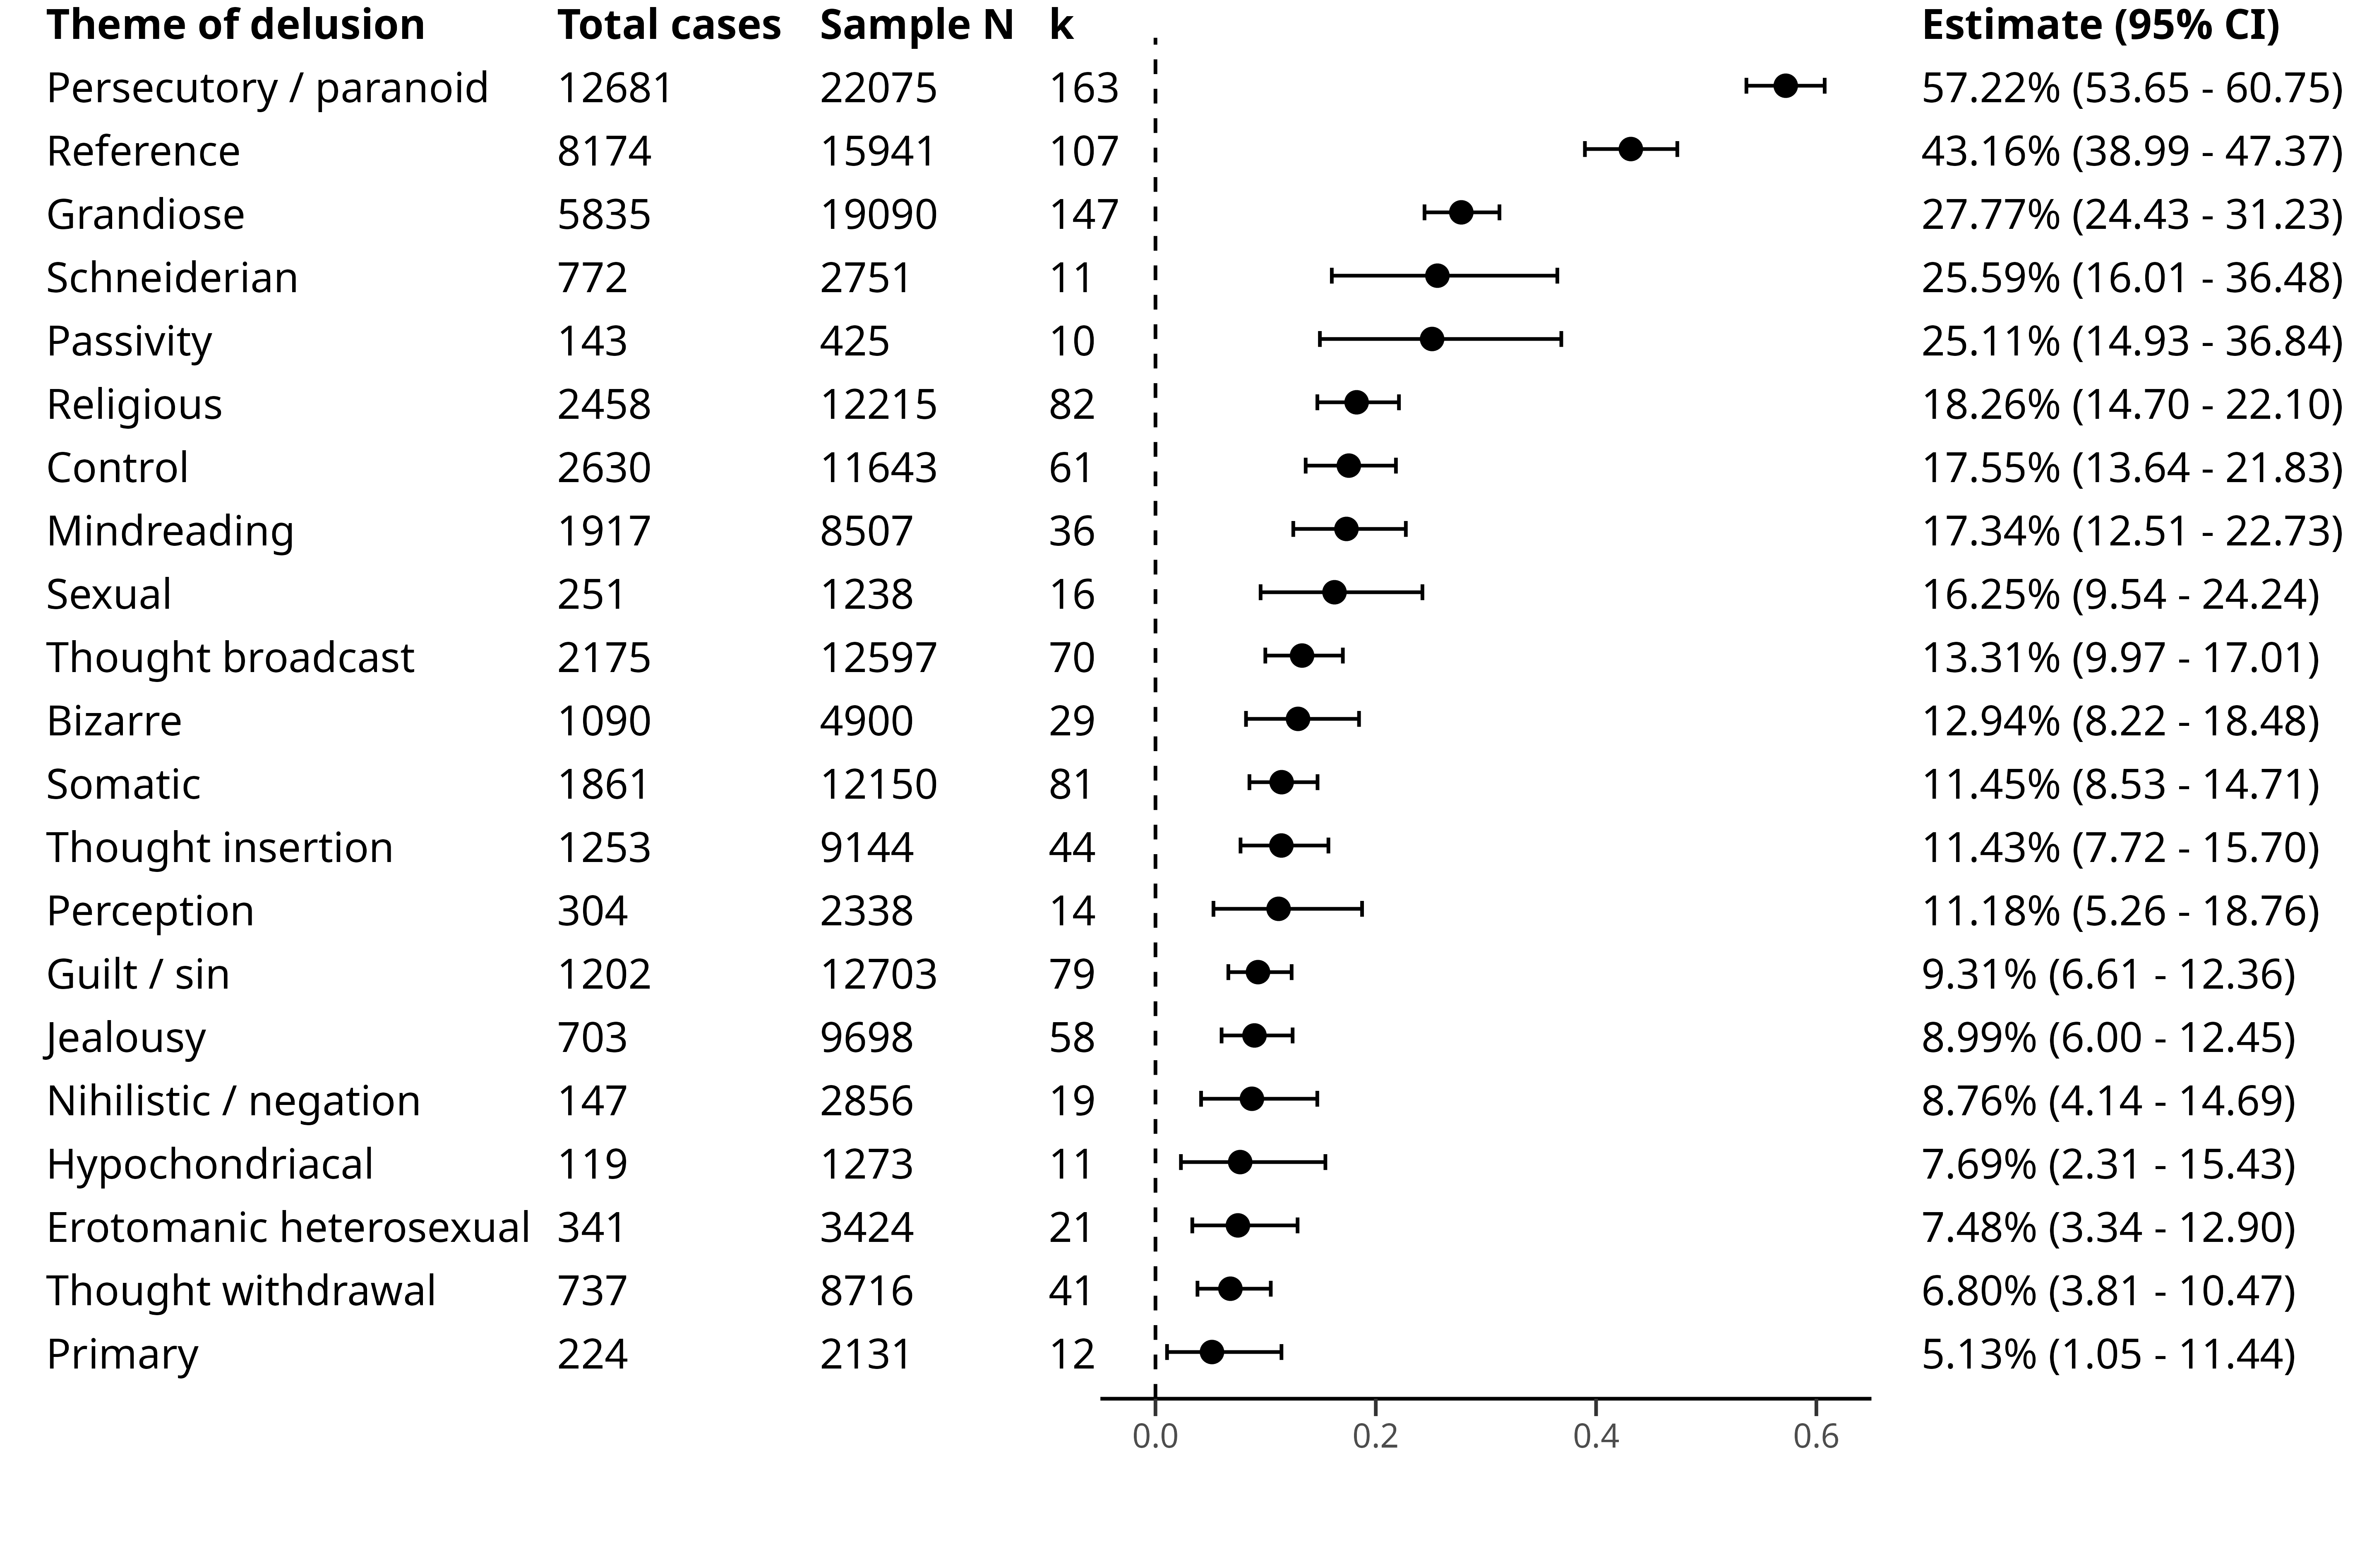

In [29]:
plot <- 1
filename = "/home/main/Dropbox/Studies/EllieDelusionsSysReview/AnalysisCode/figures/figure2_main_forest_plot.png"
main_forest_plot <- forester_plot(estimate_df, 0.65, filename)
display_png(file = filename, width = 1000)

### Descriptive statistics

In [32]:
sprintf("Total number of studies selected: %d", length(unique(delus_themes_data$study)))
sprintf("Total number of studies included in meta-analysis: %d", length(unique(delus_themes_data_recoded_min_k$study)))
sprintf("Total number of samples included with k>=10 per theme rule: %d", length(unique(delus_themes_data_recoded_min_k$study_sample)))
sprintf("Total number of patients included with k>=10 per theme rule: %d", sum(delus_themes_data_recoded_min_k$psychotic_n))

[1] "Total number of samples selected: 155"

[1] "Total number of studies included in meta-analysis: 111"

[1] "Total number of samples included with k>=10 per theme rule: 174"

[1] "Total number of patients included with k>=10 per theme rule: 175815"

In [33]:
# Calculate descriptive statistics 
vars_by_study_sample <- delus_themes_data_recoded_min_k %>%
  group_by(study_sample) %>%
  reframe(
    publishedyear = unique(publishedyear),
    percentfemales = unique(percentfemales),
    agemean = unique(agemean),
    psychosisdurationyears = unique(psychosisdurationyears),
    percentantipsychoticmedication = unique(percentantipsychoticmedication),
    country = unique(country),
    diagnosiscoded = unique(diagnosiscoded),
    setting = unique(setting),
    ethnicity = unique(ethnicity),
    scale = unique(scale)
  )

# Replace all blanks with NAs
vars_by_study_sample <- vars_by_study_sample %>%
  mutate_all(~replace(., . == "", NA))

# Give vars human readable labels
label(vars_by_study_sample$publishedyear) <- "Pubished year"
label(vars_by_study_sample$agemean) <- "Age"
label(vars_by_study_sample$percentfemales) <- "% Female"
label(vars_by_study_sample$psychosisdurationyears) <- "Psychosis duration (years)"
label(vars_by_study_sample$percentantipsychoticmedication) <- "% Antipsychotic meds"

# Give vars human readable labels
label(vars_by_study_sample$country) <- "Country"
label(vars_by_study_sample$diagnosiscoded) <- "Diagnosis"
label(vars_by_study_sample$setting) <- "Setting"
label(vars_by_study_sample$ethnicity) <- "Ethnicity"
label(vars_by_study_sample$scale) <- "Measurement scale"

In [34]:
# Display nicely formatted table of continuous variable descriptives and save to HTML file
continuous_desc_table <- table1(~ publishedyear + agemean + percentfemales + psychosisdurationyears + percentantipsychoticmedication, data = vars_by_study_sample)
t1flex(continuous_desc_table) %>%
  save_as_html(path="/home/main/Dropbox/Studies/EllieDelusionsSysReview/AnalysisCode/figures/tableS4.html")
display_html(file = "/home/main/Dropbox/Studies/EllieDelusionsSysReview/AnalysisCode/figures/tableS4.html")

,Overall(N=174)
Pubished year,
Mean (SD),2010 (11.8)
"Median [Min, Max]","2010 [1980, 2020]"
Age,
Mean (SD),36.9 (7.53)
"Median [Min, Max]","37.1 [22.2, 56.6]"
Missing,27 (15.5%)
% Female,
Mean (SD),0.480 (0.210)
"Median [Min, Max]","0.473 [0, 1.00]"


In [35]:
# Display nicely formatted table of factor variable descriptives and save to HTML file
factor_desc_table <- table1(~ country + diagnosiscoded + setting + ethnicity + scale, data = vars_by_study_sample)
t1flex(factor_desc_table) %>%
  save_as_html(path="/home/main/Dropbox/Studies/EllieDelusionsSysReview/AnalysisCode/figures/tableS5.html")
display_html(file = "/home/main/Dropbox/Studies/EllieDelusionsSysReview/AnalysisCode/figures/tableS5.html")

,Overall(N=174)
Country,
Australia,18 (10.3%)
Brazil,2 (1.1%)
Canada,7 (4.0%)
China,2 (1.1%)
Denmark,7 (4.0%)
Egypt,3 (1.7%)
France,3 (1.7%)
Germany,9 (5.2%)
Greece,2 (1.1%)
